### Whole-brain model 

In [1]:
import sys

sys.path.insert(1, "/home/vinicius/Documentos/phase_amplitude_encoding/")

In [2]:
import jax
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from frites.core import copnorm_nd
from hoi.core import get_mi
from mne.time_frequency.tfr import tfr_array_morlet
from tqdm import tqdm

from src.models import simulate, simulate_delayed

/home/vinicius/anaconda3/envs/test_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
jax.config.update("jax_platform_name", "cpu")

#### Load anatomical data

In [4]:
data = np.load("../interareal/markov2014.npy", allow_pickle=True).item()

# Graph parameters
Nareas = 29  # Number of areas
# FLN matrix
flnMat = data["FLN"]
# Distance matrix
D = data["Distances"] * 1e-3 / 3.5
# Hierarchy values
h = np.squeeze(data["Hierarchy"].T)

eta = 4.0

#### Simulation parameters

In [5]:
ntrials = 200
fsamp = 1 / 1e-4
time = np.arange(-2, 5, 1 / fsamp)
beta = 1e-3
Npoints = len(time)
decim = 15
f = 40  # np.linspace(20, 60, Nareas)[::-1]  # Node natural frequency in Hz

flnMat = (1 + eta * h)[:, np.newaxis] * flnMat

Iext = np.zeros(Npoints)
Iext[(time >= 0) & (time <= 0.4)] = 1
Amplitudes = np.linspace(0, 100, ntrials)

In [6]:
Iext = np.zeros((Nareas, Npoints))
Iext[0, (time >= 0) & (time <= 0.4)] = 1
Amplitudes = np.linspace(0, 10, ntrials)
CS = Amplitudes[..., None, None] * Iext
seeds = np.random.randint(0, 10000, ntrials)

In [7]:
out = []
for trial in tqdm(range(ntrials)):
    """
    out += [
        simulate_hopf(
            flnMat,
            Iext * Amplitudes[trial],
            f,
            -5,
            fsamp,
            beta,
            Npoints,
            trial,
            decim=decim,f
        )
    ]
    """
    out += [
        simulate(
            flnMat,
            Iext[0] * trial,
            f, 
            -5,
            fsamp,
            beta,
            Npoints,
            0,  # CS[trial] * Iext,
            seeds[trial],
            decim=decim,
            stim_mode="both",
        )
    ]

100%|████████████████████████████████████████████████████████| 80/80 [01:20<00:00,  1.00s/it]


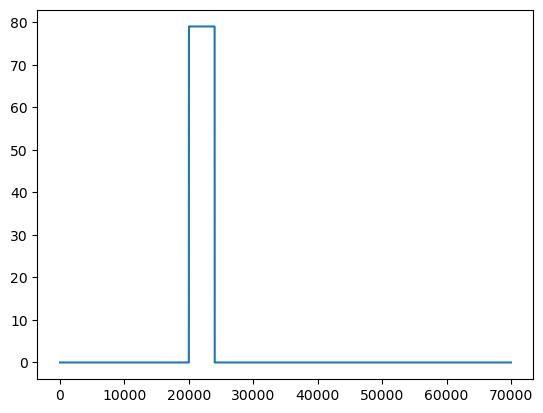

In [8]:
plt.plot(Iext[0] * trial)

In [9]:
np.stack(out).shape

(80, 29, 4667)

#### Convert to xarray

In [10]:
np.stack(out).shape

(80, 29, 4667)

In [11]:
area_names = [
    "V1",
    "V2",
    "V4",
    "DP",
    "MT",
    "8m",
    "5",
    "8l",
    "TEO",
    "2",
    "F1",
    "STPc",
    "7A",
    "46d",
    "10",
    "9/46v",
    "9/46d",
    "F5",
    "TEpd",
    "PBr",
    "7m",
    "7B",
    "F2",
    "STPi",
    "PROm",
    "F7",
    "8B",
    "STPr",
    "24c",
]

data = xr.DataArray(
    np.stack(out),
    dims=("trials", "roi", "times"),
    coords=(Amplitudes, area_names, time[::decim]),
)

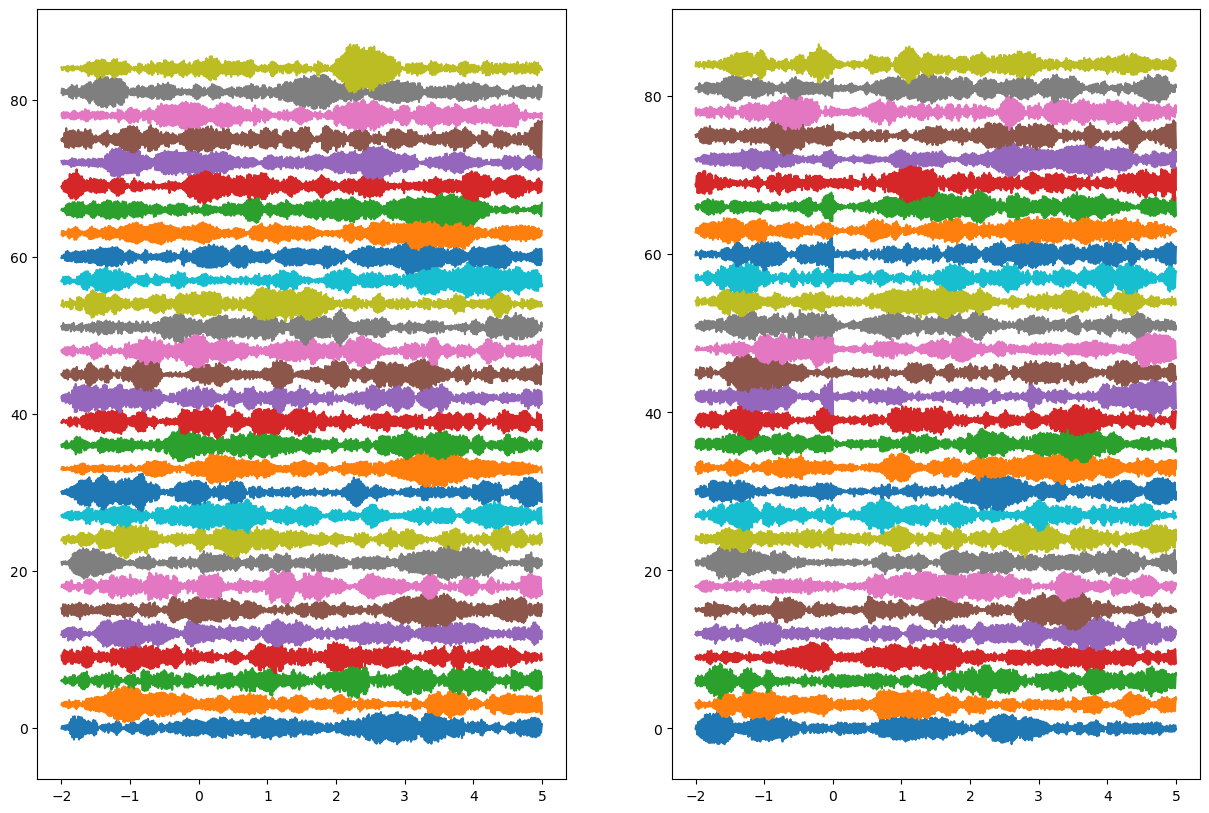

In [12]:
plt.figure(figsize=(15, 10))
z_data = (data - data.mean("times")) / data.std("times")
plt.subplot(1, 2, 1)
for i in range(Nareas):
    plt.plot(z_data[-1].times, z_data[0].values[i].real + (i * 3))
plt.subplot(1, 2, 2)
for i in range(Nareas):
    plt.plot(z_data[-1].times, z_data[-1].values[i].real + (i * 3))

In [13]:
time[::decim].shape

(4667,)

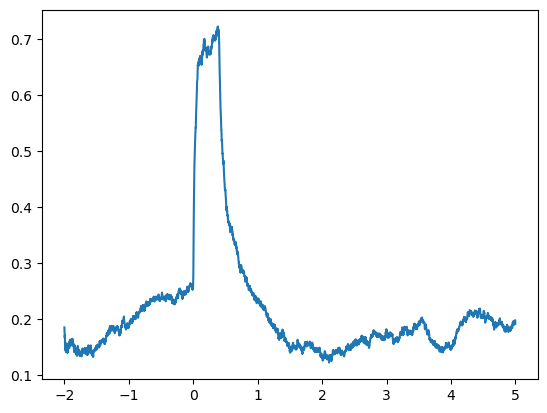

In [14]:
import scipy

theta = np.angle(scipy.signal.hilbert(data.real, axis=2))

plt.plot(data.times, np.abs(np.exp(1j * theta).mean(axis=1)).mean(0))

#### Decompose in time-frequency domain


In [15]:
data = data.sel(times=slice(-0.2, 3))


freqs = np.linspace(0.3, 80, 30)

S = tfr_array_morlet(
    data.values.real,
    fsamp / decim,
    freqs,
    freqs / 7,
    output="complex",
    n_jobs=1,
    zero_mean=False,
    verbose=True,
)

S = xr.DataArray(
    S,
    dims=("trials", "roi", "freqs", "times"),
    coords={"freqs": freqs, "times": data.times.values, "roi": area_names},
)

100%|████████████████████████████████████████████████████████| 28/28 [01:07<00:00,  2.40s/it]


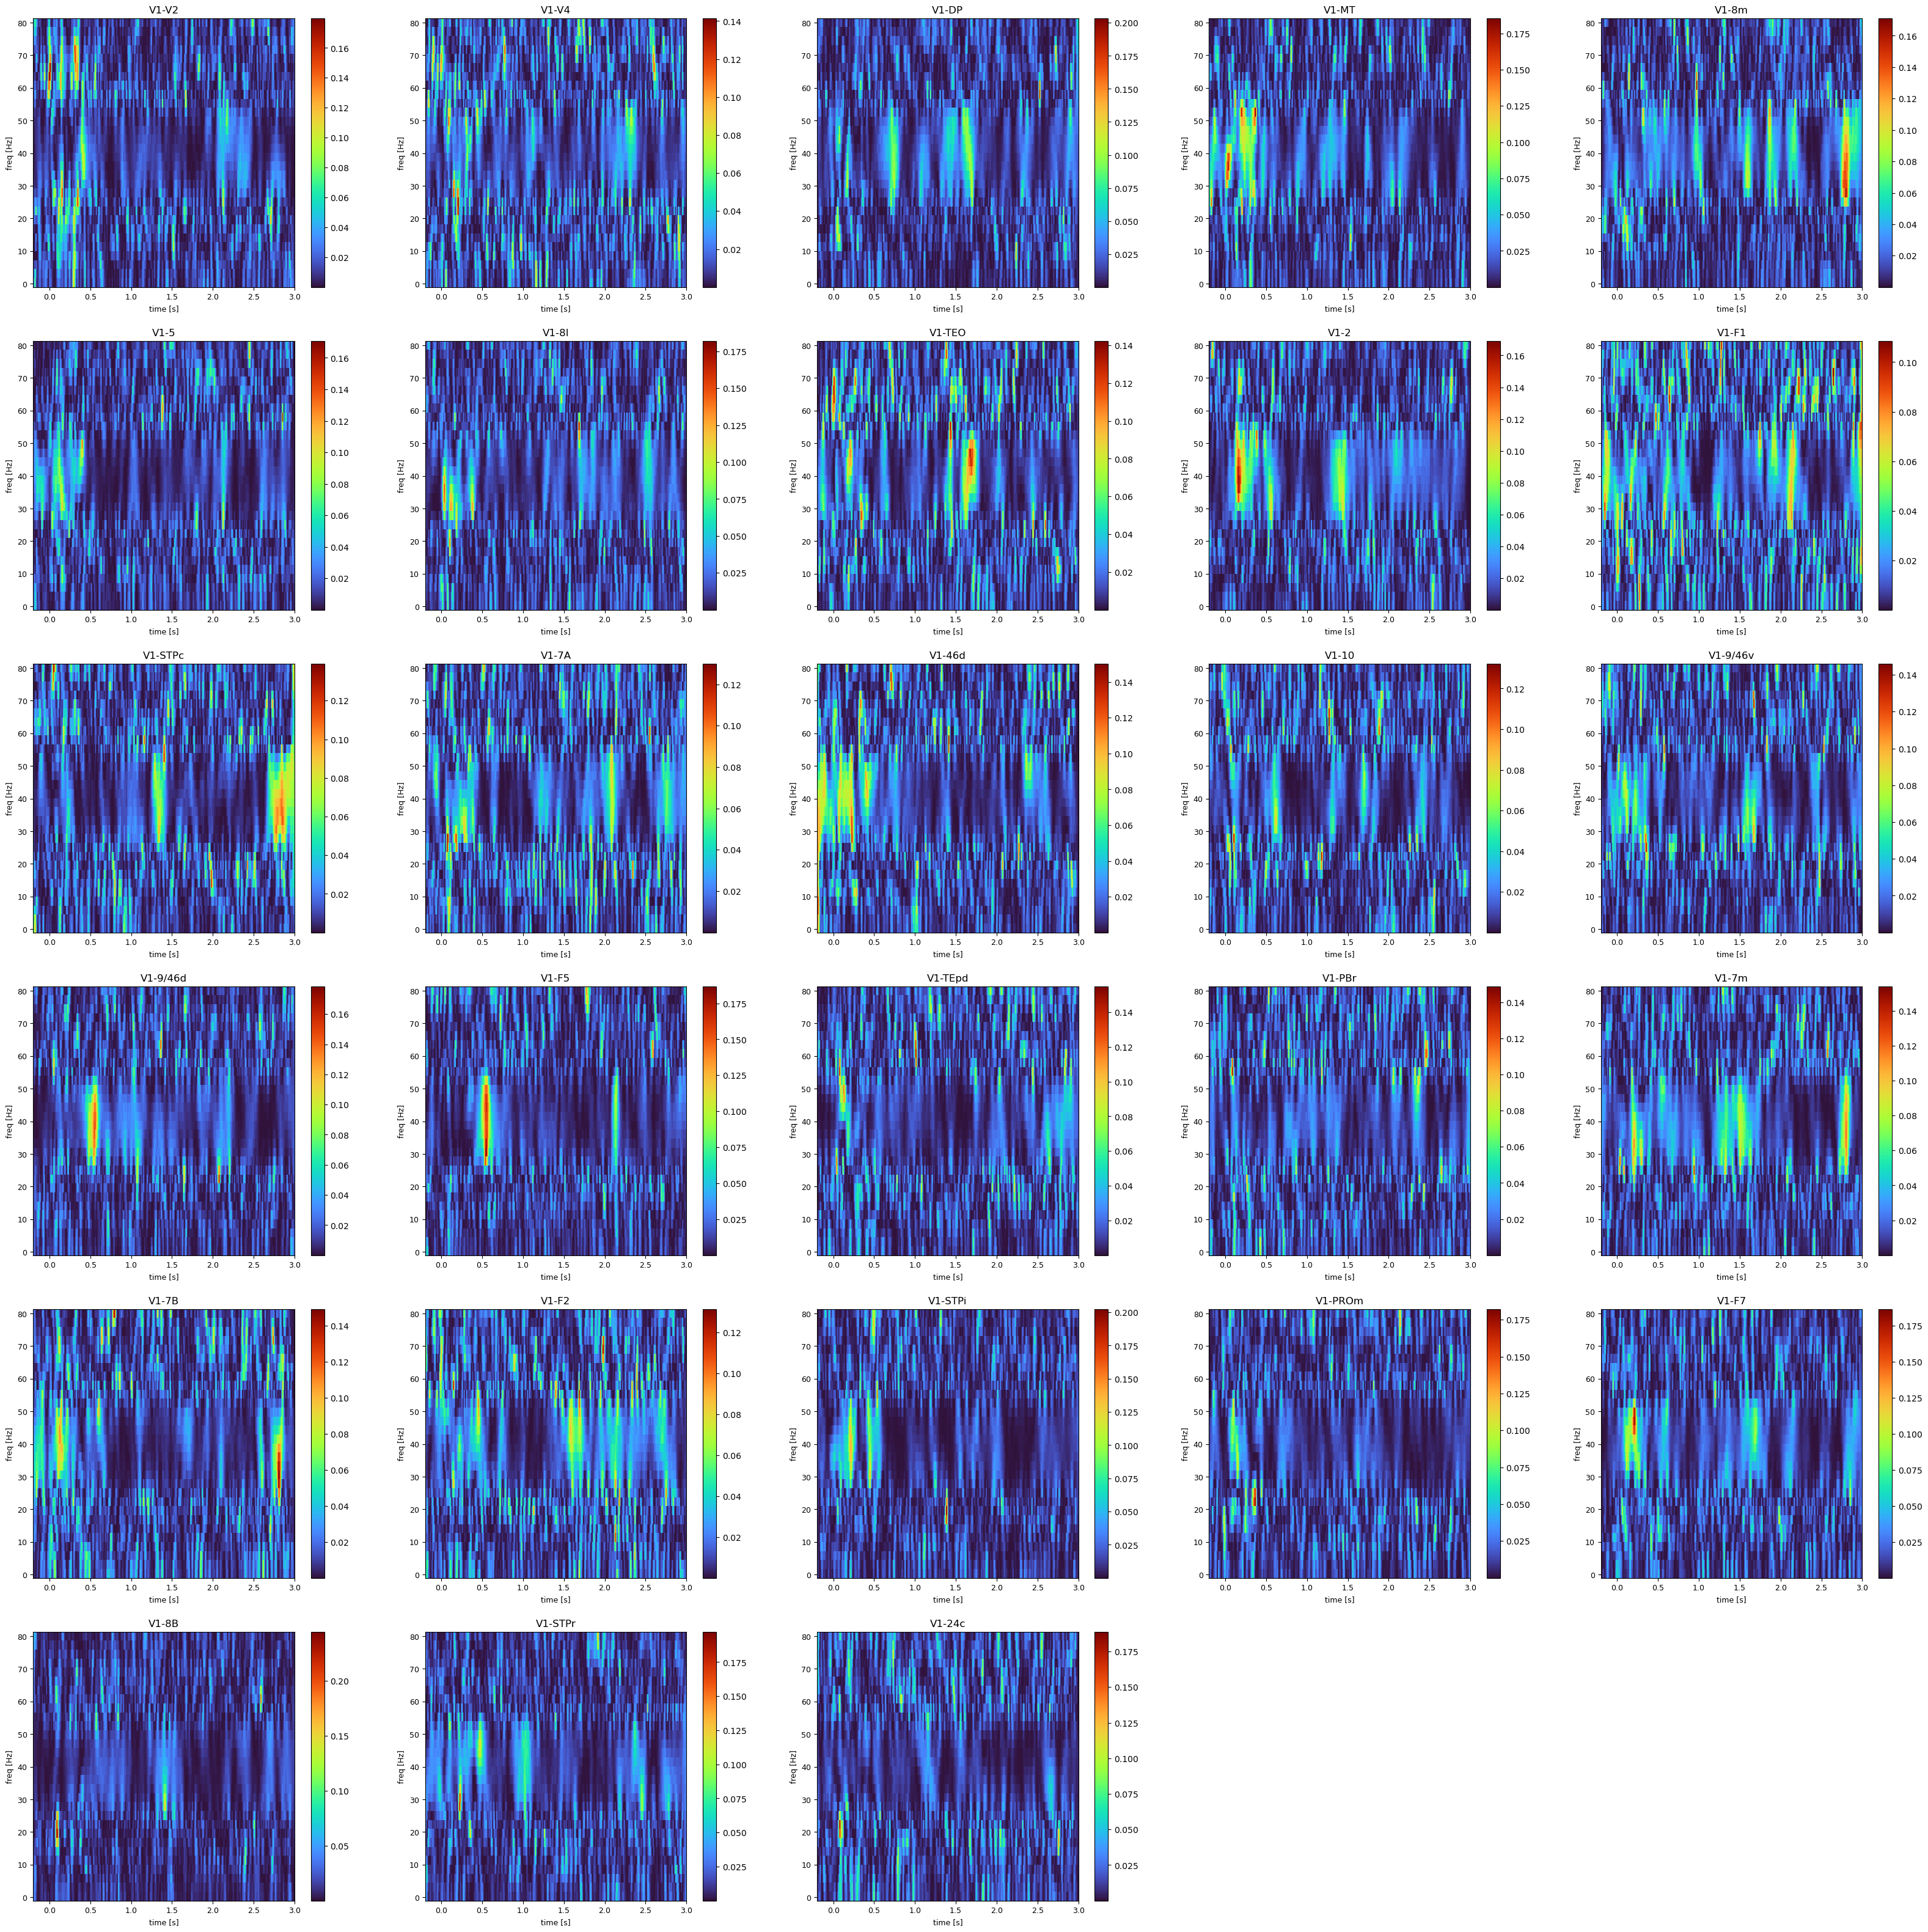

In [16]:
### Compute phase and amplitude terms


def _mi(S, roi_x, roi_y, stim):

    # Define the function to compute MI using HOI and JAX
    mi_fcn = get_mi("gc")

    # vectorize the function to first and second dimension
    gcmi = jax.vmap(jax.vmap(mi_fcn, in_axes=0), in_axes=0)

    times, freqs = S.times.values, S.freqs.values
    x = S.sel(roi=[roi_x]).data.squeeze()
    y = S.sel(roi=[roi_y]).data.squeeze()

    edge = x * np.conj(y)
    edge_r, edge_i = np.real(edge), np.imag(edge)

    E1 = np.stack((edge_r, edge_i), axis=1)
    E1 = np.moveaxis(E1, [0, 1], [-1, -2])

    # Stims across trials
    stim = data.trials.values
    stim = np.expand_dims(stim, axis=(0, 1))
    stim = np.tile(stim, (len(freqs), data.sizes["times"], 1, 1))

    E1 = copnorm_nd(E1, axis=-1)
    stim = copnorm_nd(stim, axis=-1)

    mi = gcmi(E1, stim).T

    return xr.DataArray(mi, dims=("times", "freqs"), coords=(times, freqs))


pairs = np.stack([[[0] * 28], [range(1, 29)]], axis=1).squeeze().T

rois = S.roi.values
stim = np.arange(100)  # data.trials.values

out = []
for i, j in tqdm(pairs):
    out += [_mi(S, rois[i], rois[j], stim)]


plt.figure(figsize=(40, 40))

for pos, _out in enumerate(out):
    plt.subplot(6, 5, pos + 1)
    i, j = pairs[pos]
    _out.T.plot(
        cmap="turbo",
    )
    plt.title(f"{rois[i]}-{rois[j]}")
    plt.xticks(fontsize=9)
    plt.yticks(fontsize=9)
    plt.ylabel("freq [Hz]", fontsize=9)
    plt.xlabel("time [s]", fontsize=9)

In [17]:
x = data.sel(roi="V1") * np.conj(data.sel(roi="V2"))

R1 = (x * np.conj(x)).data.real
R2 = np.unwrap(np.angle(x))

In [18]:
# Stims across trials
stim = np.expand_dims(Amplitudes, axis=(0, 1))
stim = np.tile(stim, (data.sizes["times"], 1)).squeeze().T

Text(0.5, 0, 'time [s]')

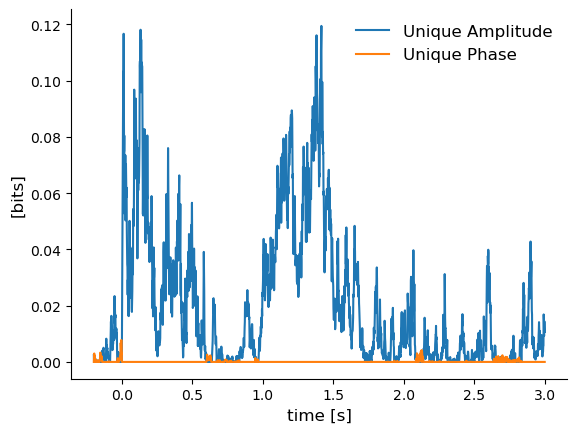

In [19]:
from frites.core import copnorm_nd, gccmi_nd_ccc, gcmi_1d_cc, gcmi_nd_cc

ax = plt.subplot(111)
I_S_12 = gccmi_nd_ccc(R1, R2, stim, traxis=0)
I_S_1 = gcmi_nd_cc(stim, R1, traxis=0)
I_S_2 = gcmi_nd_cc(stim, R2, traxis=0)
R_12 = np.minimum(I_S_1, I_S_2)

# plt.plot(S.times.values, I_S_12)
plt.plot(x.times.values, I_S_1 - R_12)
plt.plot(x.times.values, I_S_2 - R_12)
plt.legend(
    ["Unique Amplitude", "Unique Phase"],
    fontsize=12,
    frameon=False,
)
[ax.spines[key].set_visible(False) for key in ["top", "right"]]
plt.ylabel("[bits]", fontsize=12)
plt.xlabel("time [s]", fontsize=12)

In [20]:
theta = np.angle(scipy.signal.hilbert(data.real, axis=2))

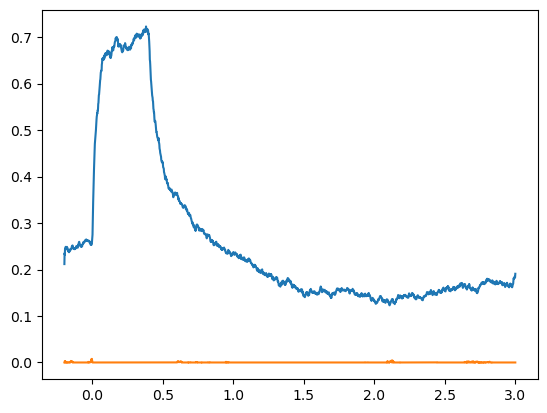

In [21]:
plt.plot(x.times.values, np.abs(np.exp(1j * theta).mean(axis=1)).mean(0))
plt.plot(x.times.values, I_S_2 - R_12)

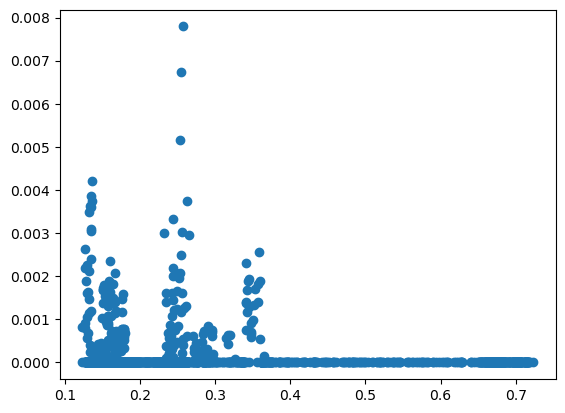

In [22]:
plt.scatter(np.abs(np.exp(1j * theta).mean(axis=1)).mean(0), I_S_2 - R_12)

In [23]:
flnMat

array([[0.00000000e+00, 7.32157206e-01, 1.27730344e-01, 4.90637041e-04,
        5.88525474e-02, 0.00000000e+00, 0.00000000e+00, 2.14684119e-04,
        2.70345555e-02, 0.00000000e+00, 0.00000000e+00, 1.65352036e-03,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 3.63082400e-03, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 4.32133484e-04,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.93697711e-05,
        0.00000000e+00],
       [1.29868965e+00, 0.00000000e+00, 2.57389171e-01, 7.16302487e-04,
        6.07721187e-02, 4.19718726e-05, 0.00000000e+00, 1.85233663e-04,
        5.56884130e-03, 0.00000000e+00, 0.00000000e+00, 1.48656485e-04,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 1.79043257e-03, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.18151577e-04,
        0.00000000e+00, 0.00000000e+00,

In [24]:
-5 - 10 * flnMat.sum(0)

array([-18.99483809, -30.87769971, -44.81372164,  -7.07233152,
       -15.81957706, -39.09578164, -13.17422895, -13.30307895,
       -19.18770061, -21.54205725, -26.25284451, -24.38512584,
       -38.64001849, -32.54224487, -18.29172763, -12.50648908,
       -40.05416645, -32.72356338, -16.60935562, -32.68309119,
       -10.1387149 , -10.02860625, -36.87988892, -51.481831  ,
        -9.27736035, -26.31147992, -21.88935835, -12.70753529,
       -17.16366189])